# Setup

In [2]:
from google.colab import drive

drive.mount("/content/drive")
stt3795 = "drive/MyDrive/STT3795"

Mounted at /content/drive


In [3]:
import os
import pickle
import re
import warnings
import csv

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from absl import logging
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.manifold import MDS, Isomap
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

warnings.filterwarnings("ignore")

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print("Module %s loaded" % module_url)
# print(model.summary())

# Télécharger les ressources nécessaires pour NLTK
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")

Module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Functions

In [10]:
def generate_stats(tn, fp, fn, tp):
    # Generate stats
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    npv = tn / (tn + fn) if tn != 0 or fn != 0 else None
    spec = tn / (tn + fp)
    acc = (tp + tn) / (tn + fn + fp + tp)
    bacc = (rec + spec) / 2
    f1 = 2 * (prec * rec) / (prec + rec)
    mcc = (tp * tn - fp * fn) / (2 * np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))) + 0.5
    return [prec, rec, npv, spec, acc, f1, mcc]

def make_stats_graph(name, model_stats, rand_stats, save_path=None):
    # Setup list of stats and labels

    labels = np.array(["Precision", "Recall", "NPV", "Specificity", "Accuracy", "F1 score", "MCC"])
    markers = [0, 0.2, 0.4, 0.6, 0.8, 1]

    # Plot figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)

    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)
    ax.set_thetagrids(angles * 180 / np.pi, labels)
    angles = np.concatenate((angles, [angles[0]]))

    model_stats = np.concatenate((model_stats, [model_stats[0]]))
    ax.plot(angles, model_stats, "o-", linewidth=2)
    ax.fill(angles, model_stats, alpha=0.25)
    rand_stats = np.concatenate((rand_stats, [rand_stats[0]]))
    ax.plot(angles, rand_stats, "--", linewidth=2)
    plt.yticks(markers)
    ax.set_title(name)
    ax.grid(True)

    if save_path is not None:
        plt.savefig(f"{save_path}/{name}")

    plt.show()

In [5]:
def extract_data_msr(filepath):
    df = pd.read_csv(filepath, delimiter="\t+", header=None)[1:]

    # Re-index from 0
    df.index = np.arange(0, len(df))

    # Extract data
    labels = df[0].to_list()
    tags = df[1].to_list()
    tags.extend(df[2].to_list())
    data = df[3].to_list()
    data.extend(df[4].to_list())
    return labels, tags, data

def extract_data_qqp(filepath, size=None):
    df = pd.read_csv(filepath, delimiter="\t+", header=None)[1:]

    # Re-index from 0
    df.index = np.arange(0, len(df))

    if size is None:
        size = len(df[5].to_list())

    # Extract data
    labels = df[5].to_list()[:size]
    tags = df[1].to_list()[:size]
    tags.extend(df[2].to_list()[:size])
    data = df[3].to_list()[:size]
    data.extend(df[4].to_list()[:size])
    return labels, tags, data


In [6]:
def prep_data(data_train, data_test, do_tokenize=True):
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()

    # Prepare training data
    for i in range(len(data_train)):
        # Standardize text
        data_train[i] = data_train[i].strip().lower()

        # Tokenize
        tokens = word_tokenize(data_train[i])

        # Lemmatize (trunkate words)
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        # Remove stop words
        tokens = list(filter(lambda token: token not in stop_words, tokens))

        # Update data
        if do_tokenize:
            data_train[i] = tokens
        else:
            data_train[i] = " ".join(tokens)

    # Prepare test data
    if do_tokenize:
        data_test = [word_tokenize(x.strip().lower()) for x in data_test]
    else:
        data_test = [x.strip().lower() for x in data_test]

    return data_train, data_test


def embed(input):
    return model(input)


def train_doc2vec_model(data, tags):
    # Get tagged data
    tagged_data = [TaggedDocument(words=x, tags=str(tags[i])) for i, x in enumerate(data)]

    # Train the Doc2Vec model
    model = Doc2Vec(vector_size=40, min_count=2, epochs=50)
    model.build_vocab(tagged_data)
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

    return model

def get_embeddings(data_train, tags_train, data_test, method=0, do_train_model=True):
    """
    Method:
        - 0: Universal Sentence Encoder
        - 1: Doc2Vec
        - 2: CountVectorizer
        - 3: TF-IDF
    """
    do_tokenize = method == 1
    data_train, data_test = prep_data(data_train, data_test, do_tokenize)

    # Use Universal Sentence Encoder model
    if method == 0:
        vectors_train = embed(data_train)
        vectors_test = embed(data_test)
    # Use Doc2Vec
    elif method == 1:
        if do_train_model:
            doc2vec_model = train_doc2vec_model(data_train, tags_train)
            doc2vec_model.save(f"{stt3795}/doc2vec.model")
        else:
            doc2vec_model = Doc2Vec.load(f"{stt3795}/doc2vec.model")

        vectors_train = [doc2vec_model.infer_vector(x) for x in data_train]
        vectors_test = [doc2vec_model.infer_vector(x) for x in data_test]
    # Use CountVectorizer
    elif method == 2:
        count_vectorizer = CountVectorizer()
        vectors_train = count_vectorizer.fit_transform(data_train).toarray()
        vectors_test = count_vectorizer.transform(data_test).toarray()
    # Use TfidfVectorizer
    elif method == 3:
        tfidf_vectorizer = TfidfVectorizer()
        vectors_train = tfidf_vectorizer.fit_transform(data_train).toarray()
        vectors_test = tfidf_vectorizer.transform(data_test).toarray()

    # Return Vectors
    return vectors_train, vectors_test


def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


def merge_vector(vectors, use_cosine_similarity=True):
    n = len(vectors) // 2
    merged = []
    if use_cosine_similarity:
        # Compute the cosine similarity
        for i in range(n):
            x1 = np.array(vectors[i]).tolist()
            x2 = np.array(vectors[n + i]).tolist()
            merged.append(cosine_similarity(x1, x2))
        merged = np.array(merged).reshape(-1, 1)
    else:
        # Associated vectors are concatenated
        for i in range(n):
            x1 = np.array(vectors[i]).tolist()
            x2 = np.array(vectors[n + i]).tolist()
            x1.extend(x2)
            merged.append(x1)

    return merged


def fit_models(data_train, labels_train, data_test, labels_test, image_path, print_stats_graph=False, method=None):
    models = {
        "Random classifier": DummyClassifier(strategy="uniform"),
        "Decision Tree (Gini)": DecisionTreeClassifier(criterion="gini"),
        "Decision Tree (Entropy)": DecisionTreeClassifier(criterion="entropy"),
        "SVM (RBF kernel)": SVC(kernel="rbf"),
        "SVM (linear kernel)": SVC(kernel="linear"),
        "Multinomial Naive Bayes": MultinomialNB(),
        "Gaussian Naive Bayes": GaussianNB(),
        "Random Forest (10 trees, d=None)": RandomForestClassifier(n_estimators=10, max_depth=None),
        "Random Forest (100 trees, d=None)": RandomForestClassifier(n_estimators=100, max_depth=None),
        "Random Forest (500 trees, d=None)": RandomForestClassifier(n_estimators=500, max_depth=None),
        "Random Forest (10 trees, d=20)": RandomForestClassifier(n_estimators=10, max_depth=20),
        "Random Forest (100 trees, d=20)": RandomForestClassifier(n_estimators=100, max_depth=20),
        "Random Forest (500 trees, d=20)": RandomForestClassifier(n_estimators=500, max_depth=20),
        "Random Forest (10 trees, d=100)": RandomForestClassifier(n_estimators=10, max_depth=100),
        "Random Forest (100 trees, d=100)": RandomForestClassifier(n_estimators=100, max_depth=100),
        "Random Forest (500 trees, d=100)": RandomForestClassifier(n_estimators=500, max_depth=100),
    }

    # Random classifier for comparison
    data_train = np.array(data_train)
    data_test = np.array(data_test)
    model = DummyClassifier(strategy="uniform")
    model.fit(data_train, labels_train)
    predicted = model.predict(x_test)
    score = model.score(data_test, labels_test)
    score_cv = cross_val_score(model, data_test, labels_test)
    tn, fp, fn, tp = confusion_matrix(labels_test, predicted).ravel()
    rand_stats = generate_stats(tn, fp, fn, tp)

    # The other models
    for key, model in models.items():
        try:
            print("====================")
            print(f"Using {key} method")
            model.fit(data_train, labels_train)

            predicted = model.predict(x_test)
            score = model.score(data_test, labels_test)
            score_cv = cross_val_score(model, data_test, labels_test)

            tn, fp, fn, tp = confusion_matrix(labels_test, predicted).ravel()

            print("| Score:", score)
            print("| Cross-val score: %0.3f (+/- %0.2f)" % (score_cv.mean(), score_cv.std() * 2))
            print(f"| Confusion matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
            if print_stats_graph:
                make_stats_graph(key, generate_stats(tn, fp, fn, tp), rand_stats, image_path)
        except:
            print(f"| Failure")


# Running

In [ ]:
# labels_train, tags_train, data_train = extract_data_msr(f"{stt3795}/MRPC/msr_paraphrase_train.txt")
# labels_test, tags_test, data_test = extract_data_msr(f"{stt3795}/MRPC/msr_paraphrase_test.txt")
labels_train, tags_train, data_train = extract_data_qqp(f"{stt3795}/QQP/train.tsv")
labels_test, tags_test, data_test = extract_data_qqp(f"{stt3795}/QQP/dev.tsv")

In [ ]:
"""
Method:
    - 0: Universal Sentence Encoder
    - 1: Doc2Vec
    - 2: CountVectorizer
    - 3: TF-IDF
"""
method = 0
do_train_model = True  # Only used for Doc2Vec
use_cosine_similarity = True

for method in range(0, 1):
    print("=====================")
    print(f"Method {method}")
    print("=====================")

    # Load data
    labels_train, tags_train, data_train = extract_data_msr(f"{stt3795}/MRPC/msr_paraphrase_train.txt")
    labels_test, tags_test, data_test = extract_data_msr(f"{stt3795}/MRPC/msr_paraphrase_test.txt")

    # Train
    try:
        vectors_train, vectors_test = get_embeddings(data_train, tags_train, data_test, method, do_train_model)
        x_train = merge_vector(vectors_train, use_cosine_similarity)
        x_test = merge_vector(vectors_test, use_cosine_similarity)
    except:
        print("Failure")
        continue
    fit_models(x_train, labels_train, x_test, labels_test, f"{stt3795}/images/mrpc-qqp/{method}", print_stats_graph=False)

# Analysis

## Embeddings

In [ ]:
labels_train, tags_train, data_train = extract_data_msr(f"{stt3795}/MRPC/msr_paraphrase_train.txt")
labels_test, tags_test, data_test = extract_data_msr(f"{stt3795}/MRPC/msr_paraphrase_test.txt")
# labels_train, tags_train, data_train = extract_data_qqp(f"{stt3795}/QQP/train.tsv", size=8000)
# labels_test, tags_test, data_test = extract_data_qqp(f"{stt3795}/QQP/dev.tsv", size=8000)

In [ ]:
"""
Method:
    - 0: Universal Sentence Encoder
    - 1: Word2Vec
    - 2: CountVectorizer
    - 3: TF-IDF
"""
method = 0
do_train_word2vec = False  # Only used when use_universal_sentence_encoder == False
vectors_train, vectors_test = get_embeddings(data_train, tags_train, data_test, method, do_train_word2vec)

In [ ]:
use_cosine_similarity = True
x_train = merge_vector(vectors_train, use_cosine_similarity)
del vectors_train, vectors_test, tags_train, tags_test, data_train, data_test, labels_test

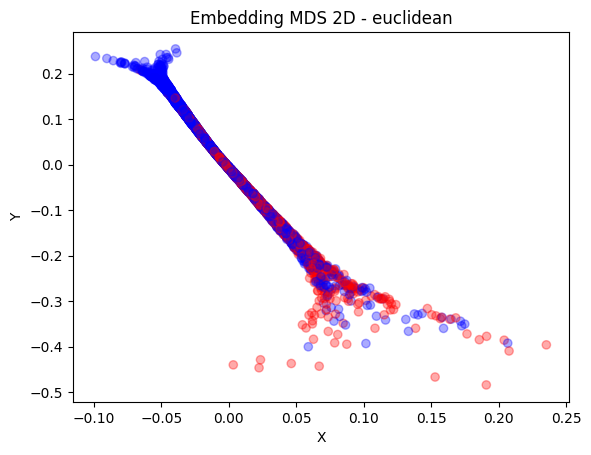

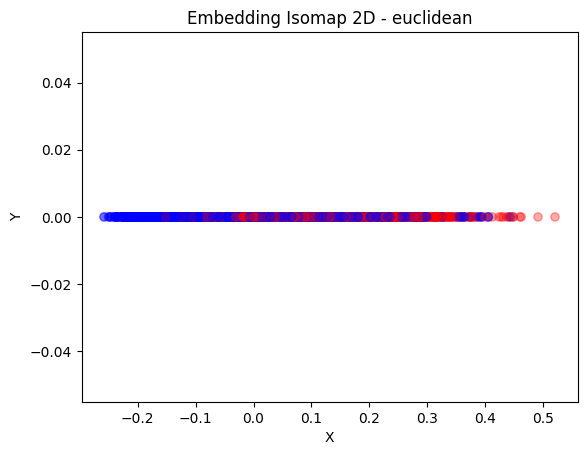

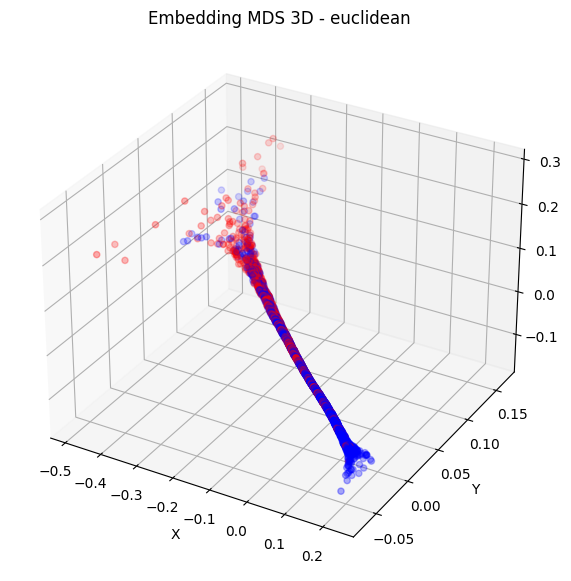

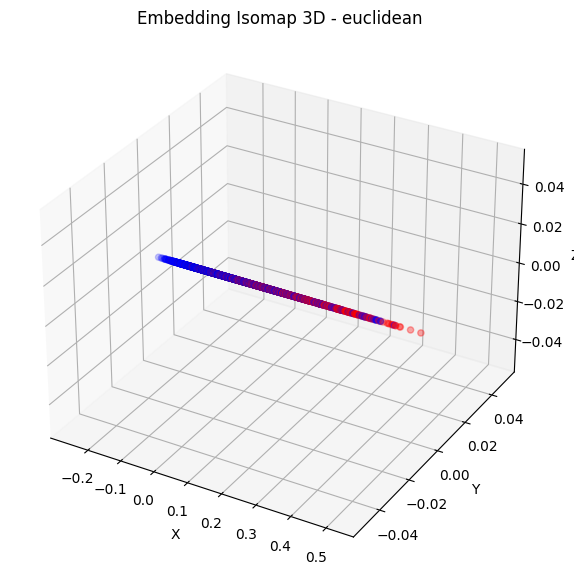

In [ ]:
input = x_train
distance_euclidean = cdist(input, input, 'euclidean')
distance_mahalanobis = cdist(input, input, 'mahalanobis')
distance_minkowski = cdist(input, input, 'minkowski')
distance_rogerstanimoto = cdist(input, input, "rogerstanimoto")
# distance_hamming = cdist(input, input, 'hamming')
# distance_jaccard = cdist(input, input, 'jaccard')

distances = {
    "euclidean": distance_euclidean,
    "mahalanobis": distance_mahalanobis,
    "minkowski": distance_minkowski,
    # "rogerstanimoto": distance_rogerstanimoto,
    # "hamming": distance_hamming,
    # "jaccard": distance_jaccard,
    }

embedding_mds_2d = MDS(n_components=2, n_jobs=-1, dissimilarity="precomputed")
embedding_mds_3d = MDS(n_components=3, n_jobs=-1, dissimilarity="precomputed")
embedding_isomap_2d = Isomap(n_components=2, n_jobs=-1, metric="precomputed")
embedding_isomap_3d = Isomap(n_components=3, n_jobs=-1, metric="precomputed")
embedding_pca_2d = PCA(n_components=2)
embedding_pca_3d = PCA(n_components=3)

for name, distance in distances.items():
    transformed_mds_2d = embedding_mds_2d.fit_transform(distance)
    transformed_mds_3d = embedding_mds_3d.fit_transform(distance)
    transformed_isomap_2d = embedding_isomap_2d.fit_transform(distance)
    transformed_isomap_3d = embedding_isomap_3d.fit_transform(distance)

    c = np.array(labels_train).ravel()
    c = list(map(lambda x: "#00F5" if x=="1" else "#F005", c))

    # Plot plongement 2D MDS
    scatter = plt.scatter(transformed_mds_2d[:, 0], transformed_mds_2d[:, 1], c=c)
    plt.xlabel("X")
    plt.ylabel("Y")
    path = f"Embedding MDS 2D - {name}"
    plt.title(path)
    plt.savefig(f"{stt3795}/images/proj/{path}")
    plt.show()

    # Plot plongement 2D Isomap
    scatter = plt.scatter(transformed_isomap_2d[:, 0], transformed_isomap_2d[:, 1], c=c)
    plt.xlabel("X")
    plt.ylabel("Y")
    path = f"Embedding Isomap 2D - {name}"
    plt.title(path)
    plt.savefig(f"{stt3795}/images/proj/{path}")
    plt.show()

    # Plot plongement 3D MDS
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(transformed_mds_3d[:, 0], transformed_mds_3d[:, 1], transformed_mds_3d[:, 2], c=c)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    path = f"Embedding MDS 3D - {name}"
    plt.title(path)
    plt.savefig(f"{stt3795}/images/proj/{path}")
    plt.show()


    # Plot plongement 3D Isomap
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(transformed_isomap_3d[:, 0], transformed_isomap_3d[:, 1], transformed_isomap_3d[:, 2], c=c)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    path = f"Embedding Isomap 3D - {name}"
    plt.title(path)
    plt.savefig(f"{stt3795}/images/proj/{path}")
    plt.show()


transformed_pca_2d = embedding_pca_2d.fit_transform(distance)
transformed_pca_3d = embedding_pca_3d.fit_transform(distance)

# Plot plongement 2D PCA
scatter = plt.scatter(transformed_pca_2d[:, 0], transformed_pca_2d[:, 1], c=c)
plt.xlabel("X")
plt.ylabel("Y")
path = "Embedding PCA 2D"
plt.title(path)
plt.savefig(f"{stt3795}/images/proj/{path}")
plt.show()

# Plot plongement 3D PCA
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(transformed_pca_3d[:, 0], transformed_pca_3d[:, 1], transformed_pca_3d[:, 2], c=c)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
path = "Embedding PCA 3D"
plt.title(path)
plt.savefig(f"{stt3795}/images/proj/{path}")
plt.show()

## Average Metrics

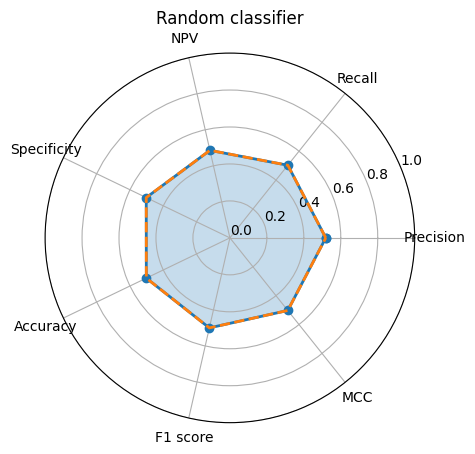

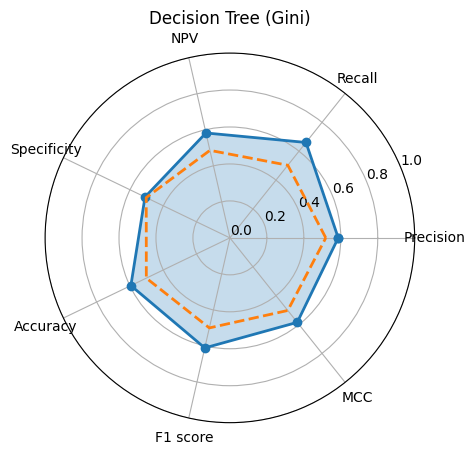

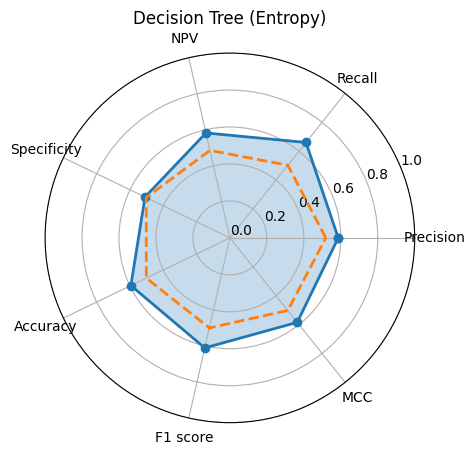

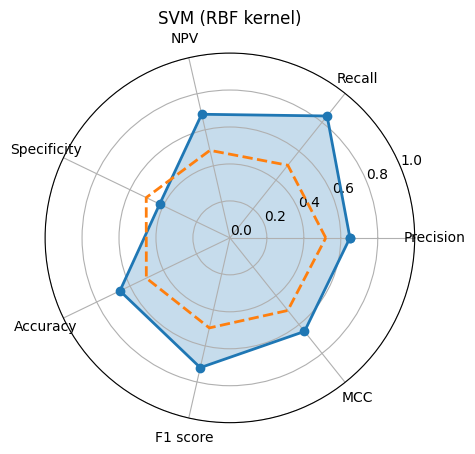

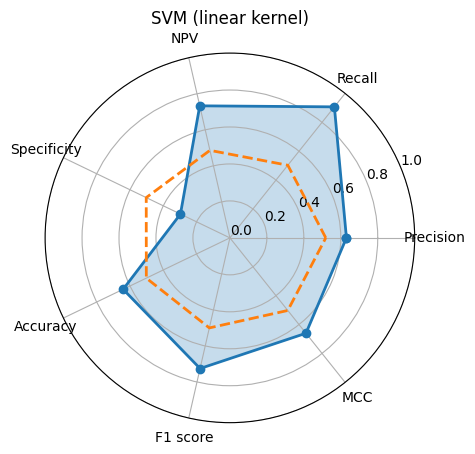

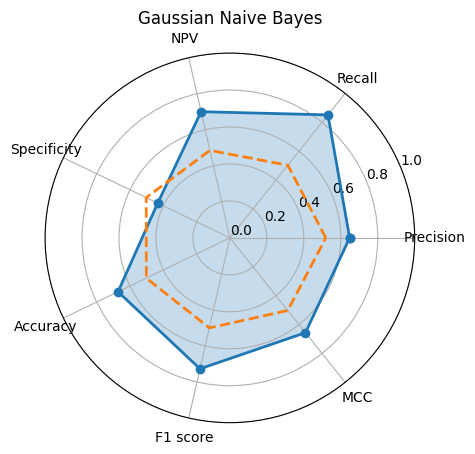

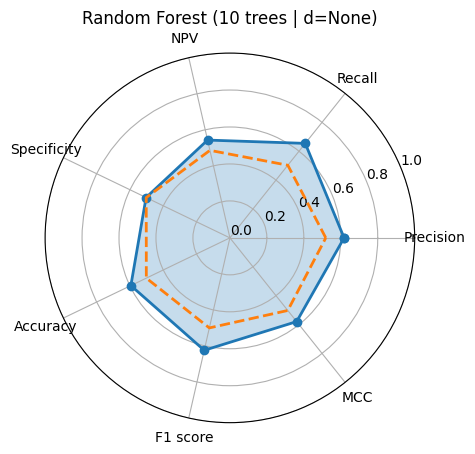

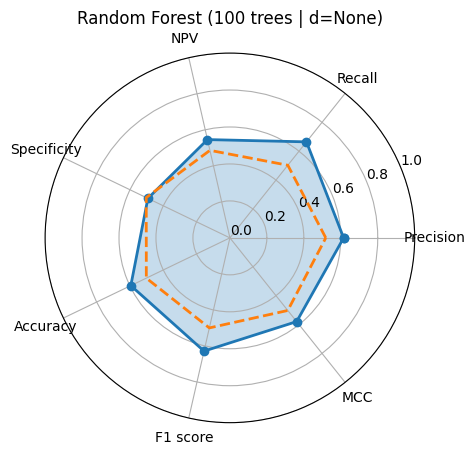

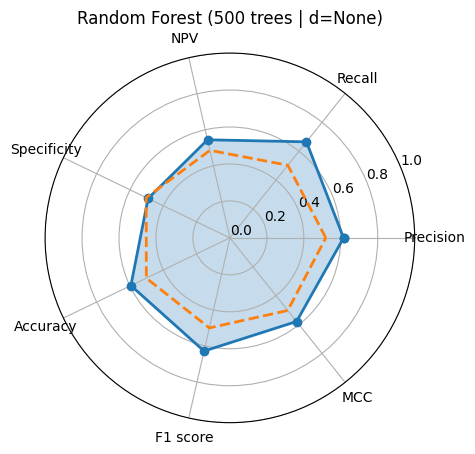

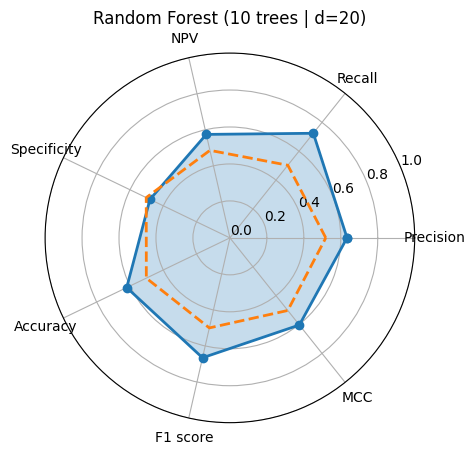

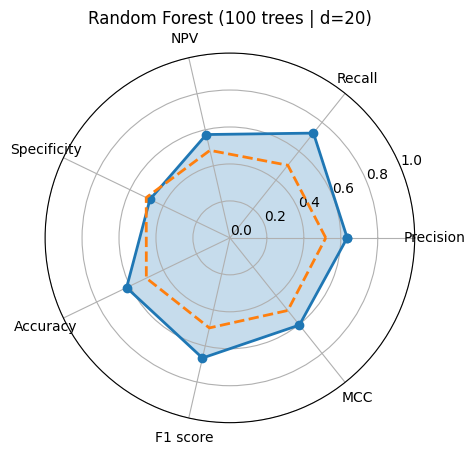

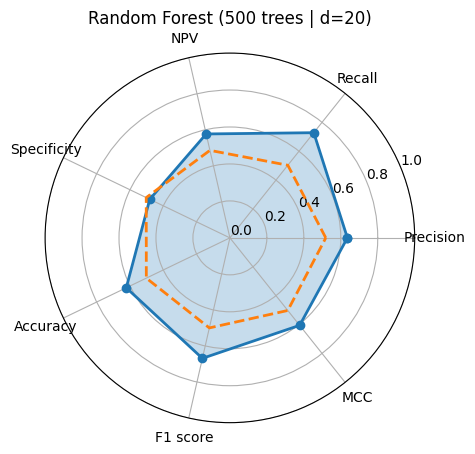

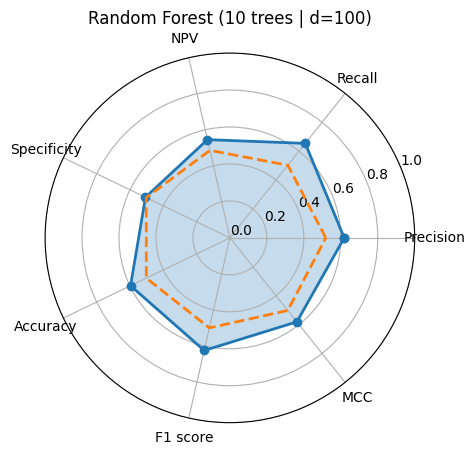

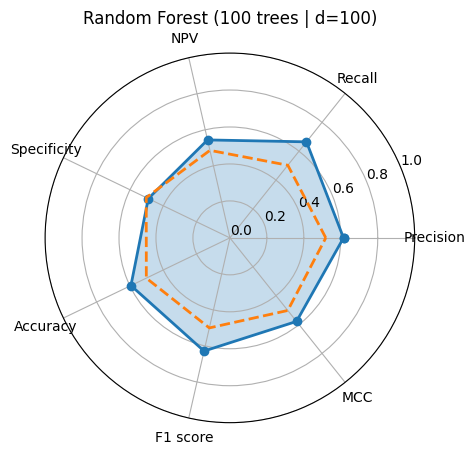

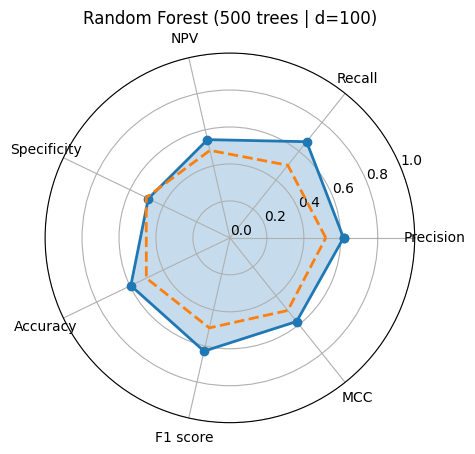

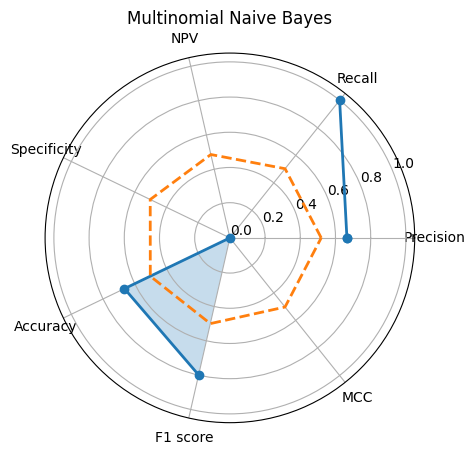

In [13]:
all_df = []
for doc in ["mrpc_qqp", "mrpc-mrpc", "qqp_msr", "qqp_qqp"]:
  df = pd.read_csv(f"{stt3795}/analysis/Sheet 2-{doc}.csv", header=None)
  all_df.append(df)

methods = {}
for df in all_df:
  m,n = df.shape
  for i in range(1, n):
    if pd.isna(df[i][m-1]):
      continue
    stats = generate_stats(int(df[i][m-3]), int(df[i][m-2]), int(df[i][m-1]), int(df[i][m-4]))
    j = 0 if m == 5 else 1
    if df[i][j] in methods:
      methods[df[i][j]].append(stats)
    else:
      methods[df[i][j]] = [stats]

rand_stats = []
for key in methods:
  tab_stats = methods[key]

  current_stats = []
  for i in range(7):
    tmp_stats = []
    for stats in tab_stats:
      if stats[i] is not None and not pd.isna(stats[i]):
        tmp_stats.append(stats[i])
    current_stats.append(np.mean(tmp_stats))
  if key == "Random classifier":
    rand_stats = current_stats
  make_stats_graph(key, current_stats, rand_stats, None)


